### On commence par travailler à partir du code ARDS.py fourni. On se demande ce qu'il fait et comment il fonctionne



0.010101010101010102 0.0009258401999814832
3189 0.00025968760037925145
3189 0.00025968760037925145
norm error= 0.22362729142313995


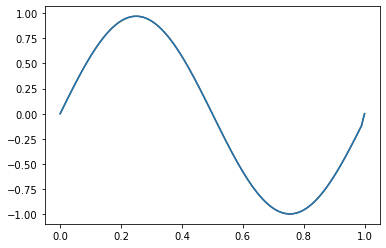

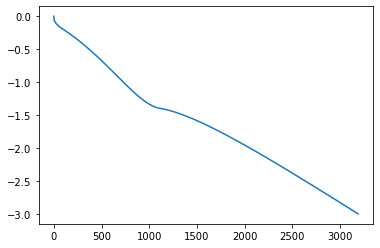

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt

#u,t = -V u,x + k u,xx  -lamda u + f

# PHYSICAL PARAMETERS
K = 0.1     #Diffusion coefficient
L = 1.0     #Domain size
Time = 20.  #Integration time


V=1
lamda=1

# NUMERICAL PARAMETERS
NX = 100  #Number of grid points
NT = 10000   #Number of time steps max
ifre=1000000  #plot every ifre time iterations
eps=0.001     #relative convergence ratio
niter_refinement=1      #niter different calculations with variable mesh size

error=np.zeros((niter_refinement))

for iter in range (niter_refinement):
#    NX=NX+3

    dx = L/(NX-1)                 #Grid step (space)
    dt = dx**2/(V*dx+K+dx**2)   #Grid step (time)  condition CFL de stabilite 10.4.5
    print(dx,dt)

    ### MAIN PROGRAM ###

    # Initialisation
    x = np.linspace(0.0,1.0,NX)
    T = np.zeros((NX)) #np.sin(2*np.pi*x)
    F = np.zeros((NX))
    rest = []
    RHS = np.zeros((NX))

    Tex = np.zeros((NX)) #np.sin(2*np.pi*x)
    Texx = np.zeros((NX)) #np.sin(2*np.pi*x)
    for j in range (1,NX-1):
        Tex[j] = np.sin(2*j*math.pi/NX)
    for j in range (1,NX-1):
        Texx[j]=(Tex[j+1]-Tex[j-1])/(2*dx)  #np.cos(j*math.pi/NX)*math.pi/NX  
        Txx=(Tex[j+1]-2*Tex[j]+Tex[j-1])/(dx**2)  #-np.sin(j*math.pi/NX)*(math.pi/NX)**2    #
        F[j]=V*Texx[j]-K*Txx+lamda*Tex[j]
        
        
    dt = dx**2/(V*dx+2*K+abs(np.max(F))*dx**2)   #Grid step (time)  condition CFL de stabilite 10.4.5

    plt.figure(1)


    # Main loop en temps
    #for n in range(0,NT):
    n=0
    res=1
    res0=1
    while(n<NT and res/res0>eps):
        n+=1
    #discretization of the advection/diffusion/reaction/source equation
        res=0
        for j in range (1, NX-1):
            xnu=K+0.5*dx*abs(V) 
            Tx=(T[j+1]-T[j-1])/(2*dx)
            Txx=(T[j-1]-2*T[j]+T[j+1])/(dx**2)
            RHS[j] = dt*(-V*Tx+xnu*Txx-lamda*T[j]+F[j])
            res+=abs(RHS[j])

        for j in range (1, NX-1):
            T[j] += RHS[j]
            RHS[j]=0


        if (n == 1 ):
            res0=res

        rest.append(res)
    #Plot every ifre time steps
        if (n%ifre == 0 or (res/res0)<eps):
            print(n,res)
            plotlabel = "t = %1.2f" %(n * dt)
            plt.plot(x,T, label=plotlabel,color = plt.get_cmap('copper')(float(n)/NT))
          

    print(n,res)
    plt.plot(x,T)

    # plt.xlabel(u'$x$', fontsize=26)
    # plt.ylabel(u'$T$', fontsize=26, rotation=0)
    # plt.title(u'ADRS 1D')
    # plt.legend()

    plt.figure(2)
    plt.plot(np.log10(rest/rest[0]))

    err=np.dot(T-Tex,T-Tex)
    errh1=0
    for j in range (1,NX-1):
        errh1+=(Texx[j]-(T[j+1]-T[j-1])/(2*dx))**2
       
    error[iter]=np.sqrt(err)
    print('norm error=',error[iter])


# plt.figure(3)
# plt.plot(x,Tex, label=plotlabel,color = plt.get_cmap('copper')(float(n)/NT))

Le code ards.py implémente une méthode numérique de type différences finies pour obtenir la solution stationnaire de  l'équation d'advection-diffusion-réaction suivante

\begin{equation}
\partial_tu=−V\partial_xu​+K\partial_{xx}u​−λu+f(x)
\end{equation}

où $f(x)=V\partial_xu_{ex}-K\partial_{xx}u_{ex}+\lambda u_{ex}$  avec $u_{ex}(x)=\exp(10(x-L/2)^2)$

En effet, la boucle en temps s'arrête lorsque le critère res/res_0<eps est atteint c'est à dire lorsque la solution est stationnaire

Dans ce code, les conditions de bords sont du type Dirichlet homogène. On le remarque car T est initialisé avec 0 comme valeur sur tous les noeuds de la maille et les valeurs aux bords restent égales à 0 (les boucles sur l'espace commencent au noeud 1 et finissent à l'avant dernier noeud).

On remarque que le terme d'advection est traité de manière décentré. Dans le code, cela se traduit par le fait que le terme d'advection est centré ET l'introduction d'une viscosité numérique (0.5*v*dx) devant le terme de diffusion. D'où les lignes de code suivantes :

In [5]:
xnu=K+0.5*dx*abs(V)
Tx=(T[j+1]-T[j-1])/(2*dx)
Txx=(T[j-1]-2*T[j]+T[j+1])/(dx**2)
RHS[j] = dt*(-V*Tx+xnu*Txx-lamda*T[j]+F[j])

pour implémenter un schéma décentré dans le cas c>0 on remplecerait les deux premières lignes par 

In [6]:
xnu=K
Tx=(T[j]-T[j-1])/dx

pour implémenter un schéma décentré dans le cas c<0 on remplacerait les deux premières lignes par 

In [7]:
xnu=K
Tx=(T[j+1]-T[j])/dx

la condition CFL respectée par le programme est

\begin{equation}
\Delta t \le \frac{\Delta x^2}{V \, \Delta x + 2 K + \max_j |F_j| \, \Delta x^2}
\end{equation}


### On trace maintenant l'erreur de convergence en norme $L^2$ et en norme $H^1$ en fonction du pas d'espace dx

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt

# =====================
# PHYSICAL PARAMETERS
# =====================
K = 0.1      # Diffusion coefficient
L = 1.0      # Domain size
Time = 20.0  # Max integration time
V = 1.0      # Convection speed
lamda = 1.0  # Reaction coefficient
eps = 1e-3   # Convergence criterion

# =====================
# NUMERICAL PARAMETERS
# =====================
NX_list = [11, 21, 41, 81, 161]  # liste de maillages pour l'étude de convergence
error_L2 = []
error_H1 = []
dx_list = []

for NX in NX_list:

    dx = L / (NX-1)
    dt = dx**2 / (V*dx + 2*K)  # CFL condition simplifiée
    NT = int(Time/dt)

    dx_list.append(dx)

    # =====================
    # INITIALISATION
    # =====================
    x = np.linspace(0.0, L, NX)
    T = np.zeros(NX)       # Solution numérique
    F = np.zeros(NX)       # Terme source
    Tex = np.zeros(NX)     # Solution exacte
    Texx = np.zeros(NX)    # Dérivée seconde exacte
    RHS = np.zeros(NX)
    rest = []

    # Solution exacte et terme source
    for j in range(1, NX-1):
        Tex[j] = np.sin(2 * j * math.pi / NX)
    for j in range(1, NX-1):
        Txx = (Tex[j+1] - 2*Tex[j] + Tex[j-1]) / dx**2
        Texx[j] = Txx
        F[j] = V * (Tex[j+1] - Tex[j-1])/(2*dx) - K*Txx + lamda*Tex[j]

    # =====================
    # TIME LOOP
    # =====================
    n = 0
    res = 1.0
    res0 = 1.0
    while n < NT and res/res0 > eps:
        n += 1
        res = 0.0

        # calcul résidu et mise à jour
        for j in range(1, NX-1):
            xnu = K + 0.5*dx*abs(V)
            Tx = (T[j+1] - T[j-1])/(2*dx)
            Txx = (T[j-1] - 2*T[j] + T[j+1]) / dx**2
            RHS[j] = dt * (-V*Tx + xnu*Txx - lamda*T[j] + F[j])
            res += abs(RHS[j])

        for j in range(1, NX-1):
            T[j] += RHS[j]
            RHS[j] = 0.0

        # Dirichlet homogène
        T[0] = 0.0
        T[-1] = 0.0

        if n == 1:
            res0 = res

        rest.append(res)

    # =====================
    # ERREURS
    # =====================
    err_L2 = np.sqrt(np.dot(T - Tex, T - Tex))
    err_H1 = 0.0
    for j in range(1, NX-1):
        dT = (T[j+1] - T[j-1])/(2*dx)
        dTex = (Tex[j+1] - Tex[j-1])/(2*dx)
        err_H1 += (dT - dTex)**2
    err_H1 = np.sqrt(err_H1)

    error_L2.append(err_L2)
    error_H1.append(err_H1)

# =====================
# PLOT ERRORS
# =====================
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].loglog(dx_list, error_L2, 'o-', label='Erreur L2')
axes[0].set_xlabel('dx')
axes[0].set_ylabel('Erreur L2')
axes[0].set_title('Convergence norme L2')
axes[0].grid(True, which="both", ls="--")

axes[1].loglog(dx_list, error_H1, 's-', label='Erreur H1')
axes[1].set_xlabel('dx')
axes[1].set_ylabel('Erreur H1')
axes[1].set_title('Convergence norme H1')
axes[1].grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()


### On cherche maintenant une majoration de la norme L2 de l'erreur

On sait qu'il existe des constantes $C$ et $k$ tels que $\lVert u-u_{ex}\rVert_{1,2}\leq Ch^k\lVert u_{ex}''\rVert_{\infty}$

On va chercher à estimer les constantes $C$ et $k$. Pour ce faire, on détermine l'erreur pour un certain nombre de pas dx, on affiche l'erreur en fonction du pas en échelle logarithmique, on réalise une régression linéaire. Moralement, on a alors:

\begin{equation}
\log(\lVert u-u_{ex}\rVert_{1,2})=\log(C\lVert u_{ex}''\rVert_\infty)+k\log(h)
\end{equation}

Ainsi, la pente de la droite obtenue par régression nous donne accès à $k$, l'ordonnée à l'origine donne accès à $C$


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math

# PHYSICAL PARAMETERS
K = 0.1       # Diffusion coefficient
L = 1.0       # Domain length
V = 1.0       # Advection velocity
lamda = 1.0   # Reaction rate
eps = 1e-5    # Convergence threshold
NT = 20000    # Max number of time steps

# MAILLAGES À TESTER
nx_values = [20,30,40,60,80,100,120,150,180]
errors = []
dx_list = []

for NX in nx_values:
    dx = L / (NX - 1)
    dt = dx**2 / (V * dx + 2 * K + dx**2)  # CFL stability condition

    x = np.linspace(0, L, NX)
    T = np.zeros(NX)
    RHS = np.zeros(NX)

    # Solution exacte continue
    Tex = np.sin(2 * np.pi * x)
    Tex_x = 2 * np.pi * np.cos(2 * np.pi * x)
    Tex_xx = - (2 * np.pi)**2 * np.sin(2 * np.pi * x)
    
    max_deriv2 = max(abs(Tex_xx))

    # Terme source f(x) construit pour que u_exact soit stationnaire
    F = V * Tex_x - K * Tex_xx + lamda * Tex

    # Évolution temporelle jusqu’à convergence
    n = 0
    res = 1.0
    res0 = 1.0
    while n < NT and res / res0 > eps:
        n += 1
        res = 0
        for j in range(1, NX - 1):
            xnu = K + 0.5 * dx * abs(V)
            Tx = (T[j + 1] - T[j - 1]) / (2 * dx)
            Txx = (T[j - 1] - 2 * T[j] + T[j + 1]) / (dx ** 2)
            RHS[j] = dt * (-V * Tx + xnu * Txx - lamda * T[j] + F[j])
            res += abs(RHS[j])

        for j in range(1, NX - 1):
            T[j] += RHS[j]

        if n == 1:
            res0 = res

    # --- Calcul de l'erreur H1 ---
    erreur = T - Tex
    
    # Approximation de la dérivée de l'erreur (différences centrées)
    erreur_x = np.zeros_like(erreur)
    erreur_x[1:-1] = (erreur[2:] - erreur[:-2]) / (2*dx)
    erreur_x[0] = (erreur[1] - erreur[0]) / dx        # bord gauche (avant)
    erreur_x[-1] = (erreur[-1] - erreur[-2]) / dx     # bord droit (avant)
    
    # Norme H1
    erreur_H1 = np.sqrt(np.sum((erreur**2 + erreur_x**2)) * dx)

    errors.append(erreur_H1)
    dx_list.append(dx)
    print(f"NX = {NX:4d}, dx = {dx:.5e}, Erreur H1 = {erreur_H1:.5e}")

# Analyse de convergence
dx_array = np.array(dx_list)
error_array = np.array(errors)

plt.figure()
plt.loglog(dx_array, error_array, 'o-', label='Erreur H1')
plt.loglog(dx_array, dx_array, label='dx')
plt.loglog(dx_array, dx_array**2, label='dx²')
plt.xlabel('Pas h (dx)')
plt.ylabel('Erreur H1')
plt.title("Convergence spatiale en norme H1")
plt.grid(True)
plt.legend()

# Régression linéaire sur log-log
coeffs = np.polyfit(np.log(dx_array), np.log(error_array), 1)
k_estime = coeffs[0]
C = np.exp(coeffs[1]) / max_deriv2
print("Ordre de convergence estimé : k =", k_estime)
print("C estimé : C =", C)

plt.show()


NX =   20, dx = 5.26316e-02, Erreur H1 = 5.39542e-01
NX =   30, dx = 3.44828e-02, Erreur H1 = 3.69681e-01
NX =   40, dx = 2.56410e-02, Erreur H1 = 2.80507e-01
NX =   60, dx = 1.69492e-02, Erreur H1 = 1.88891e-01
NX =   80, dx = 1.26582e-02, Erreur H1 = 1.42282e-01
NX =  100, dx = 1.01010e-02, Erreur H1 = 1.14091e-01
NX =  120, dx = 8.40336e-03, Erreur H1 = 9.52108e-02
NX =  150, dx = 6.71141e-03, Erreur H1 = 7.62673e-02
NX =  180, dx = 5.58659e-03, Erreur H1 = 6.36051e-02
Ordre de convergence estimé : k = 0.9572220070398183
C estimé : C = 0.2340636893594765


On obtient un ordre de convergence proche de 1 pour ce code. La constante $C$ est de l'ordre de 0.2